# Students Details
* Tomer Dwek 313229486
* Guy Kabiri 312252224

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
import cv2
from scipy.signal import  convolve2d
import random
from tqdm.auto import tqdm

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# **Part 1**

## General Functions

In [3]:
def get_random_digit_index(digit, dataset):
    (images, labels) = dataset
    while True:
        idx = random.randint(0, len(labels) - 1)
        if labels[idx] != digit:
            continue
        return idx

## 5 Samples of Each Class

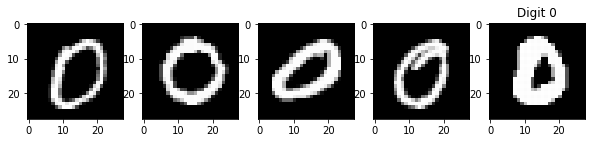

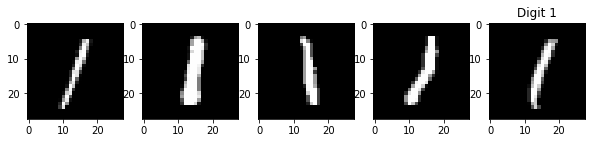

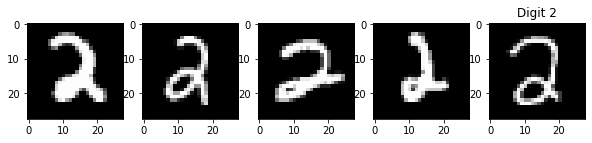

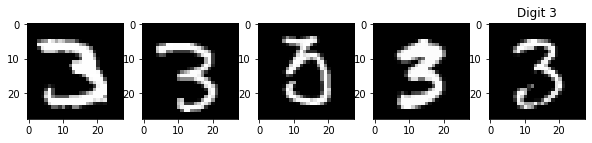

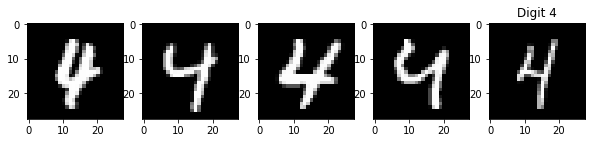

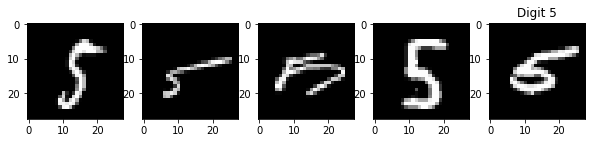

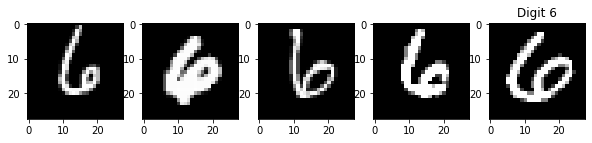

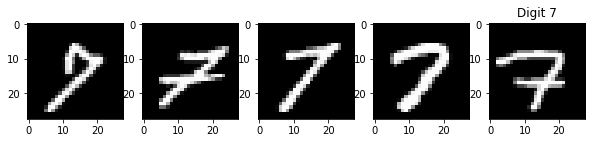

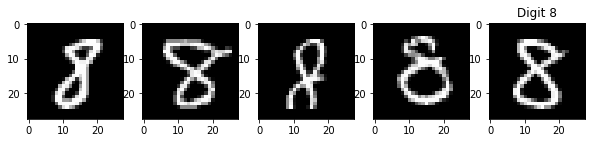

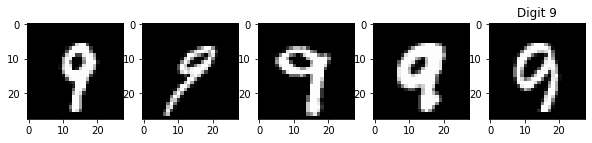

In [4]:
for digit in range(10):
    plt.figure(figsize=(10, 10))
    count = 1
    while count <= 5:
        idx = get_random_digit_index(digit, (x_train, y_train))
        plt.subplot(1, 5, count)
        plt.imshow(x_train[idx], cmap='gray')
        count += 1
    plt.title('Digit {}'.format(y_train[idx]))
    plt.show()

## Generating 3-Digit Numbers

In [6]:
num_samples = 10
digit_w = 28
digit_h = 28

In [7]:
''' 
    shape_len will be used to create the number `4` for example
    to appear in an array with size of 3 digits
    if not specified, the len will be exact as number of digits
    padding=True will pad the image in both sided if number of digits is smaller than shape_len
    padding=False will add 0-leading for numbers with less digits than shape_len
'''
def number_generator(dataset, label: int, shape_len=None, padding=False):
    (images, labels) = dataset

    str_label = str(label)
    num_of_digits = len(str_label)             #   number of digit needed for this label

    #   if length of the shape is smaller than the number of digits in the desired label
    if shape_len is not None and shape_len < num_of_digits:
        raise ValueError('`shape_len` must be equals or greater than number of digits in the desired label.')

    #   add 0-leading digits
    if padding is False and num_of_digits < shape_len:
        zeros_needed = shape_len - num_of_digits
        for i in range(zeros_needed):
            str_label = '0' + str_label

        num_of_digits = shape_len   #   update number of digits

    num = np.zeros([digit_h, digit_w * num_of_digits])      #   create an array to fit the number

    #   iterate for each digit in the string number
    for i in range(num_of_digits):
        idx = get_random_digit_index(int(str_label[i]), dataset)    #   get index of the correct digit
        num[ :, i * digit_w : i * digit_w + digit_w] = images[idx]  #   re-place it in the array

    # center the number in the array if the desire shape is greater than number of digits in the number
    if shape_len is not None and num_of_digits != shape_len:
        padd = shape_len * digit_w - num_of_digits * digit_w
        padd = int(padd / 2)
        num = np.pad(num, ((0, 0), (padd, padd)), 'constant', constant_values=(0))

    return num


In [8]:
def generate_set(dataset, num_samples=4000, num_range=100):
    (images, labels) = dataset

    new_images = []
    new_labels = []

    shape_size = len(str(num_range))

    for number in tqdm(range(num_range + 1)):
        for i in range(num_samples):
            new_images.append(number_generator(dataset, number, shape_size))
            new_labels.append(number)

    return new_images, new_labels

### Generate

In [9]:
%%time
(new_images, new_labels) = generate_set((x_train, y_train), num_samples=4000)


CPU times: user 50.8 s, sys: 6.91 s, total: 57.7 s
Wall time: 58.3 s


## Augmentation Class

In [10]:
class Augmentation:
    def __init__(self):
        pass

    @staticmethod
    # Random horizontal/vertical flip
    def flip(img):
        flip_index = np.random.randint(0, 2)
        if flip_index == 0: # vertical flip
            return img[::-1, :]
        else: # horizontal flip
            return img[:, ::-1]


    # Rotate image by angle(degrees)
    @staticmethod
    def rotate(img, angle=30):
        h, w = img.shape
        output = np.zeros_like(img)
        mid_y = round(((h + 1)/2) - 1)
        mid_x = round(((w + 1)/2) - 1)
        angle = np.deg2rad(-angle)

        new_mid_y = round(mid_y*np.cos(angle)-mid_x*np.sin(angle))
        new_mid_x = round(mid_y*np.sin(angle)+mid_x*np.cos(angle))

        x = np.arange(0, w, 1)
        y = np.arange(0, h, 1)
        xx, yy = np.meshgrid(x, y)

        n_x = ((yy * np.sin(angle) + xx * np.cos(angle)) - new_mid_x + mid_x).astype(int)
        n_y = ((yy * np.cos(angle) - xx * np.sin(angle)) - new_mid_y + mid_y).astype(int)

        for i in range(h):
            for j in range(w):
                if n_x[i][j] >= 0 and n_x[i][j] < w and n_y[i][j] >= 0 and n_y[i][j] < h:
                    output[i][j] = img[n_y[i][j]][n_x[i][j]]

        return output


    # Zoom in/out image. if the zoom value is larger than 1 zoom out, if zoom value is smaller than 1 zoom in
    @staticmethod
    def zoom(img, zoom=1):
        h, w = img.shape
        
        if zoom == 1:
            return img

        if zoom < 1: # Zoom In
            new_zoom = 1/zoom
            
            new_width = int(w * 1/zoom)
            start_x_index = int((new_width - w) / 2)
            end_x_index = int((new_width + w)/ 2)

            new_height = int(h * 1/zoom)
            start_y_index = int((new_height - h) / 2)
            end_y_index = int((new_height + h)/ 2)
        else: # Zoom Out
            new_zoom = zoom

            new_width = int(w / zoom)
            start_x_index = 0
            end_x_index = new_width

            new_height = int(h / zoom)
            start_y_index = 0
            end_y_index = new_height

        dim = (new_width, new_height)

        # resize image
        resized = cv2.resize(img, dim, fx=int(new_zoom), fy=int(new_zoom),  interpolation = cv2.INTER_AREA)
        
        if zoom > 1: # Zoom Out
            y_pad = int((h - end_y_index)/2)
            x_pad = int((w - end_x_index)/2)
            resized = np.pad(array=resized, pad_width=((y_pad, y_pad), (x_pad, x_pad)), mode='constant', constant_values=0)
        
        else: # Zoom In
            resized = resized[start_y_index : end_y_index, start_x_index : end_x_index]

        return resized


    # Crop image by start/end indexes
    @staticmethod
    def crop(img, start_y=0, end_y=100, start_x=0, end_x=50):
        h, w = img.shape
    # Check out of bound indexes
        if start_y < 0 or start_y > h:
            start_y = 0
        if end_y < 0 or end_y > h:
            end_y = h
        if start_x < 0 or start_x > w:
            start_x = 0
        if end_x < 0 or end_x > w:
            end_x = w
        return img[start_y:end_y, start_x:end_x]


    @staticmethod
    def shift(img, offset_h=10, offset_w=10):
        image = img.copy()
        image = np.roll(image, offset_h, axis=0)
        image = np.roll(image, offset_w, axis=1)
        return image


    # Sharp image using laplacian
    @staticmethod
    def sharp(img, alpha=0.20):
        laplacian = np.array(([0, -1, 0],
                              [-1, 4, -1],
                              [0, -1, 0]))
        
        delta = np.array(([0, 0, 0],
                          [0, 1, 0],
                          [0, 0, 0]))
        
        laplacian_sharper = delta + alpha * laplacian
        sharpened_img = np.abs(convolve2d(img, laplacian_sharper))
        return sharpened_img / sharpened_img.max()

    
    @staticmethod
    def lpf(img):
        mat_size = 3
        ker = np.ones([mat_size, mat_size]) / (mat_size ** 2)
        output = np.abs(convolve2d(img, ker, 'same'))
        return output / output.max()


    @staticmethod
    def hpf(img):
        mat_size = 3
        ker = np.array([[-1,-1,-1],
                        [-1,8,-1],
                        [-1,-1,-1]]) / (mat_size ** 2)
        output =  np.abs(convolve2d(img, ker, 'same'))
        return output / output.max()


    @staticmethod
    def sobel_x(img):
        mat_size = 3
        ker = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

        ker = ker / (mat_size ** 2)

        output = np.abs(convolve2d(img, ker, 'same'))
        return output / output.max()


    @staticmethod
    def sobel_y(img):
        mat_size = 3
        ker = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

        ker = ker / (mat_size ** 2)

        output = np.abs(convolve2d(img, ker, 'same'))
        return output / output.max()


    # Adding Gaussian blur to image
    @staticmethod
    def gaussian_blur(img, kernel_size=3, sigma=5, sig_range=1):
        spaced_range = np.linspace(start=-sig_range, stop=sig_range, num=kernel_size)
        xx, yy = np.meshgrid(spaced_range, spaced_range)
        g = (1 / (2 * np.pi * (sigma ** 2)))
        g = np.exp(-(xx * 2 + yy * 2) / (2 * (sigma * 2)))
        blur = g / g.sum()
        output = convolve2d(img, blur, mode='same')
        return output / output.max()



    # Adding median blur to image
    @staticmethod
    def median_blur(img, kernel_size=3):
        h, w = img.shape
        w_k, h_k = kernel_size, kernel_size

        pad_h = int(np.ceil((h - h + kernel_size) / 2) - 1)
        pad_w = int(np.ceil((w - w + kernel_size) / 2) - 1)

        res = np.zeros_like(img)
        img_paddad = np.pad(img, [pad_h, pad_w])

        for r in range(res.shape[0]):
            for c in range(res.shape[1]):
                res[r, c] = np.median(img_paddad[r:r + w_k, c:c + w_k])
        
        return res / res.max()


    @staticmethod
    def motion_blur(img, kernel_size=3):

        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
        kernel = kernel / kernel_size

        # applying the kernel to the input image
        image = cv2.filter2D(img, -1, kernel)

        return image / image.max()


    @staticmethod
    def salt_pepper_noise(img, prob=0.1):
        # Getting the dimensions of the image
        h , w = img.shape

        image = img.copy()
        
        for row_idx in range(h):
            for col_idx in range(w):
                rand = random.random()
                if rand < prob:
                    rand = random.random()
                    if rand > 0.5:
                        image[row_idx][col_idx] = 0.0
                    else:
                        image[row_idx][col_idx] = 1.0

        return image


    @staticmethod
    def erosion_dilation(img, erosion=False, kernel_size=2, iterations=1):
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        if erosion:
            output = cv2.erode(img, kernel, iterations)
        else:
            output = cv2.dilate(img, kernel, iterations)

        return output / output.max()



## Random Augmentation Class

In [11]:
class RandomAugmentation(Augmentation):
    def __init__(self):
        pass

    @staticmethod
    def random_augmentation(image, funcs, funcs_probs, num_of_augs=2):
        choices = np.random.choice(funcs, size=num_of_augs, p=funcs_probs)
        for func in choices:
            image = eval('RandomAugmentation.' + func + '(image)')
        return image

### Generate Random Augmented Numbers

### Rrelevant Augmentations
The augmentations we did not use on this data are `flip`, `zoom`, `rotate`, `crop`, and `shift`.  
Those augmentations might prevent the ability to recognize the number in the image (eg, zooming an image with a value of `006` might lead the number to appear similar to `000`).  
  

The augmentations we did choose to use on this data are `motion_blur`,`salt_pepper_noise`,`erosion_dilation`, `sobel_x`, `sobel_y`, `lpf`, `hpf`, `sharp`, `gaussian_blur`, and `median_blur`.  
Those augmentations will keep most of the data similar to the original image.

In [12]:
functions = ['motion_blur','salt_pepper_noise','erosion_dilation','sobel_x',
             'sobel_y','lpf', 'hpf', 'sharp', 'gaussian_blur', 'median_blur']

probs = [0.1 for i in functions]

augments = []
augments_label = []

for index in range(50):
    img_indx = random.randint(0, len(new_images))
    augmented = RandomAugmentation.random_augmentation(new_images[img_indx], functions, probs)
    augments.append(augmented) 
    augments_label.append(new_labels[img_indx])

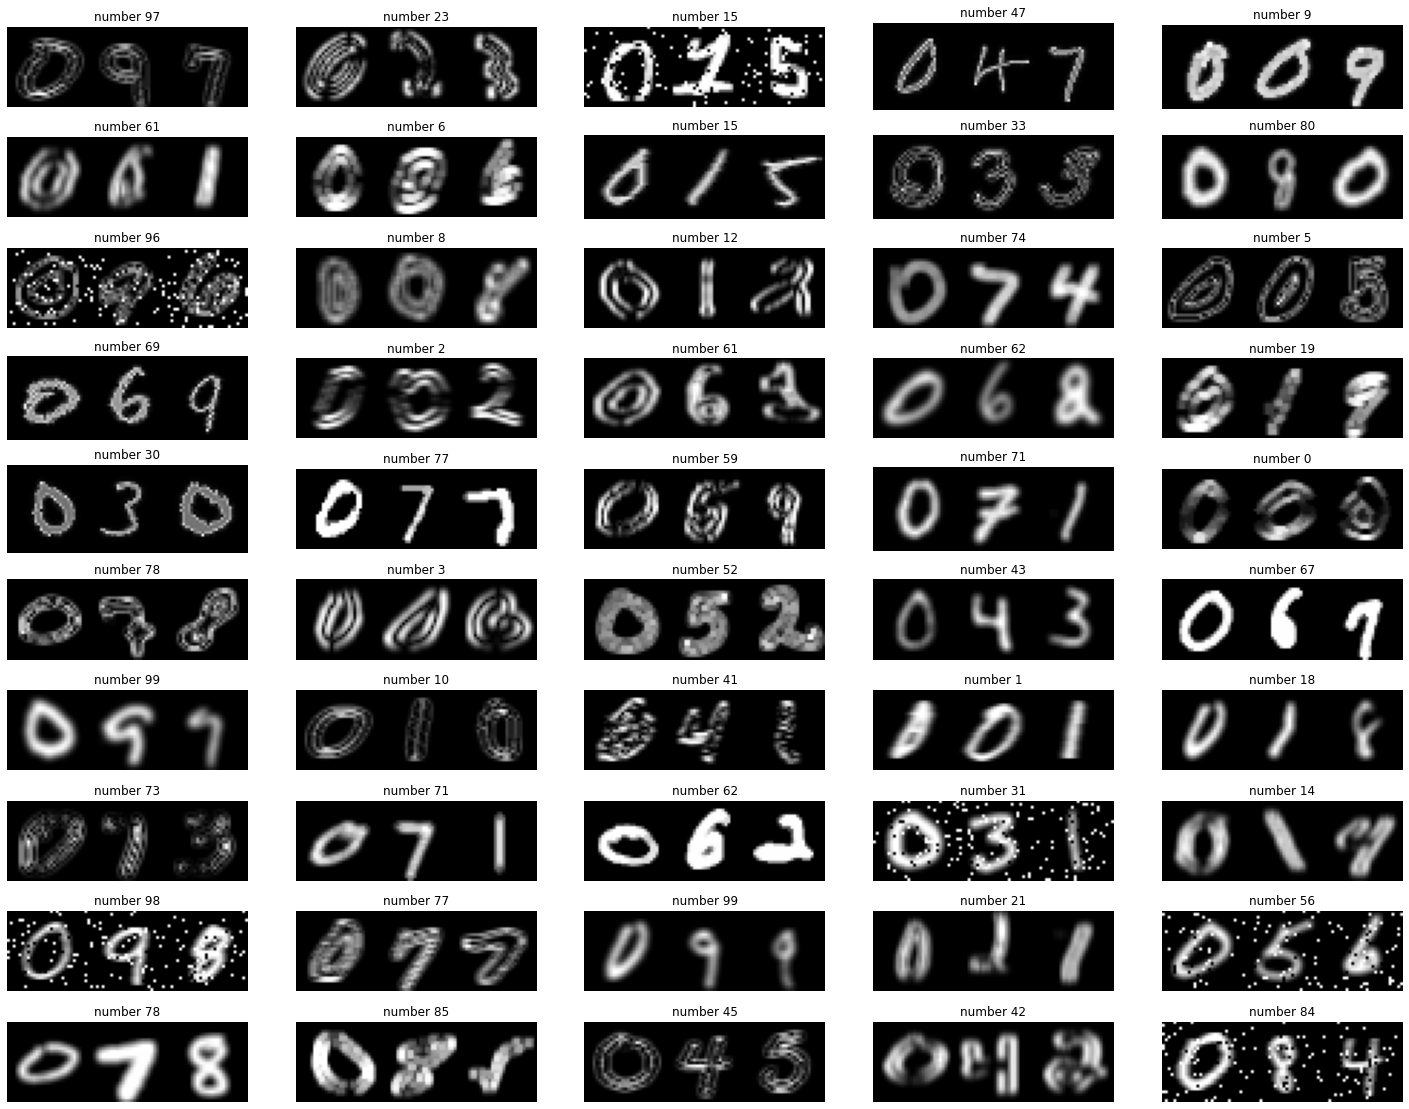

In [13]:
plt.figure(figsize=(25, 20))
for index in range(50):
    plt.subplot(10, 5, index + 1)
    plt.title('number {}'.format(augments_label[index]))
    plt.axis("off")
    plt.imshow(augments[index], cmap='gray')
    
plt.show()

## Summary 1
As instructed, we have loaded the `mnist` dataset, combined 3 images each time to a new 3-digits image, and created a set of all the numbers between 0-100 (4,000 images of each number).  
After that, we randomly augmented a bunch of images from this set and display them as shown above.

# **Part 2**

## General Functions

In [14]:
def calculate_center(points):
    sumx, sumy = 0, 0
    for p in points:
        sumx += p[0]
        sumy += p[1]
    
    n = len(points)
    return sumx // n, sumy // n

In [15]:
def rotate_points(points, angle):
    cx, cy = calculate_center(points)

    rad = np.deg2rad(angle)

    c = np.cos(rad)
    s = np.sin(rad)

    new_points = np.empty(points.shape)

    i = 0
    for p in points:
        rotated_x = c * (p[0] - cx) - s * (p[1] - cy) + cx
        rotated_y = s * (p[0] - cx) + c * (p[1] - cy) + cy
        new_p = [rotated_x, rotated_y]
        new_points[i] = new_p
        i += 1

    return new_points.astype(int)

In [16]:
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

In [17]:
def calculate_triangle_area(points):
    p1, p2, p3 = points
    a = calculate_distance(p1, p2)
    b = calculate_distance(p2, p3)
    c = calculate_distance(p3, p1)
    s = (a + b + c) / 2

    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

In [18]:
def norm(img):
    img = img.astype(np.float32)
    img -= img.min()
    img /= img.max()
    return img

In [ ]:
def conv_arr_to_gray(arr):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in arr]

## Circle

In [19]:
def circle(size: int=50):
    x = np.arange(0, size, 1)
    y = np.arange(0, size, 1)
    xx, yy = np.meshgrid(x, y)

    min_r, max_r = 5, 13
    radius = random.randint(min_r, max_r)

    offset = (size // 2) - radius
    shift_y = random.randint(-offset, offset)
    shift_x = random.randint(-offset, offset)

    r = np.sqrt((xx - shift_x + 1 - size // 2)**2 + (yy - shift_y + 1 - size //2)**2).astype(int)
    img = np.zeros((size, size, 3))
    mask = r[yy, xx] == radius
    img[mask, 0] = random.random()
    img[mask, 1] = random.random()
    img[mask, 2] = random.random()
    max_val = size // 2 - radius - 1
    return norm(img)

## Rectangle

In [20]:
def rectangle(size=50):
    img = np.zeros([size, size, 3])

    offset = 10

    w = random.randint(5, size - offset)
    h = random.randint(100 // w, min(size - offset, 600 // w))

    x = random.randint(0, size - w)
    y = random.randint(0, size - h)

    p1 = (x, y)
    p2 = (x + w, y)
    p3 = (x + w, y + h)
    p4 = (x, y + h)

    angle = random.randint(0, 180)
    new_points = rotate_points(np.array([p1, p2, p3, p4]), angle)

    x_min = np.min([p[0] for p in new_points])
    if x_min < 0:
        new_points = [[p[0] + x_min * -1, p[1]] for p in new_points]
    

    x_max = np.max([p[0] for p in new_points])
    if x_max >= size:
        new_points = [[p[0] - (x_max - size) - 1, p[1]] for p in new_points]


    y_min = min([p[1] for p in new_points])
    if y_min < 0:
        new_points = [[p[0], p[1] + y_min * -1] for p in new_points]

    y_max = max([p[1] for p in new_points])
    if y_max >= size:
        new_points = [[p[0], p[1] - (y_max - size) - 1] for p in new_points]

    p1, p2, p3, p4 = [(p[0], p[1]) for p in new_points]
    
    color = (random.random(), random.random(), random.random())

    cv2.line(img, p1, p2, color)
    cv2.line(img, p2, p3, color)
    cv2.line(img, p3, p4, color)
    cv2.line(img, p4, p1, color)

    return norm(img)

## Triangle

In [21]:
def triangle(size=50):
    img = np.zeros([size, size, 3])

    area = 0

    while not 600 >= area >= 100:
        p1 = (random.randint(0, size - 1), random.randint(0, size - 1))
        p2 = (random.randint(0, size - 1), random.randint(0, size - 1))
        p3 = (random.randint(0, size - 1), random.randint(0, size - 1))
        points = np.array([p1, p2, p3])
        area = calculate_triangle_area(points)

    color = (random.random(), random.random(), random.random())

    cv2.line(img, p1, p2, color)
    cv2.line(img, p2, p3, color)
    cv2.line(img, p3, p1, color)

    return norm(img)

## Generate Random Shapes

In [35]:
num_images = 300
rectangles  = np.array([rectangle() for i in range(num_images)])
triangles   = np.array([triangle() for i in range(num_images)])
circles     = np.array([circle() for i in range(num_images)])

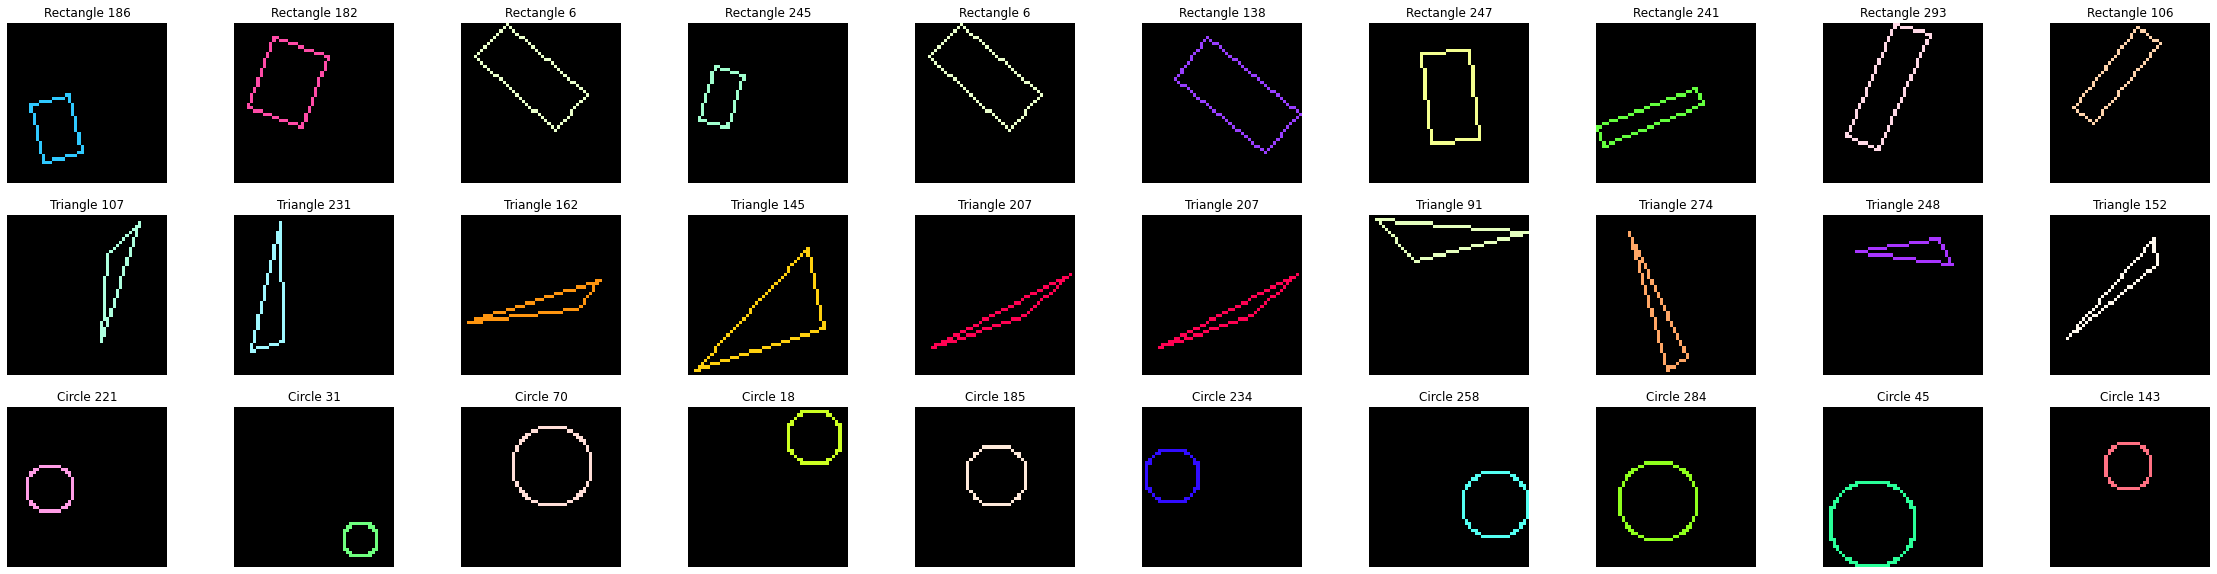

In [37]:
plt.figure(figsize=(40, 10))

img_idx = 1
for arr, arr_name in zip([rectangles, triangles, circles], ['Rectangle', 'Triangle', 'Circle']):
    for index in range(10):
        plt.subplot(3, 10, img_idx)
        idx = random.randint(0, num_images - 1)
        plt.axis("off")
        plt.title("{} {}".format(arr_name, idx))
        plt.imshow(arr[idx])
        img_idx += 1
    
plt.show()

## Generate Augmented Shaped

In [38]:
rec2d = conv_arr_to_gray(rectangles)
tri2d = conv_arr_to_gray(triangles)
cir2d = conv_arr_to_gray(circles)

In [39]:
functions = ['erosion_dilation', 'sobel_x', 'erosion_dilation', 'motion_blur',
             'sobel_y','lpf', 'hpf', 'sharp', 'salt_pepper_noise', 'gaussian_blur']


probs = [1 / len(functions)  for i in functions]

augments = []
augments_label = []

for index in range(50):
    img_indx = random.randint(0, num_images - 1)
    arr_rnd = random.randint(0, 2)
    if arr_rnd == 0:
        arr = rec2d
        label = 'Rectangle {}'.format(img_indx)
    elif arr_rnd == 1:
        arr = tri2d
        label = 'Triangle {}'.format(img_indx)
    else:
        arr = cir2d
        label = 'Circle {}'.format(img_indx)

    augmented = RandomAugmentation.random_augmentation(arr[img_indx], functions, probs)
    augments.append(augmented) 
    augments_label.append(label)

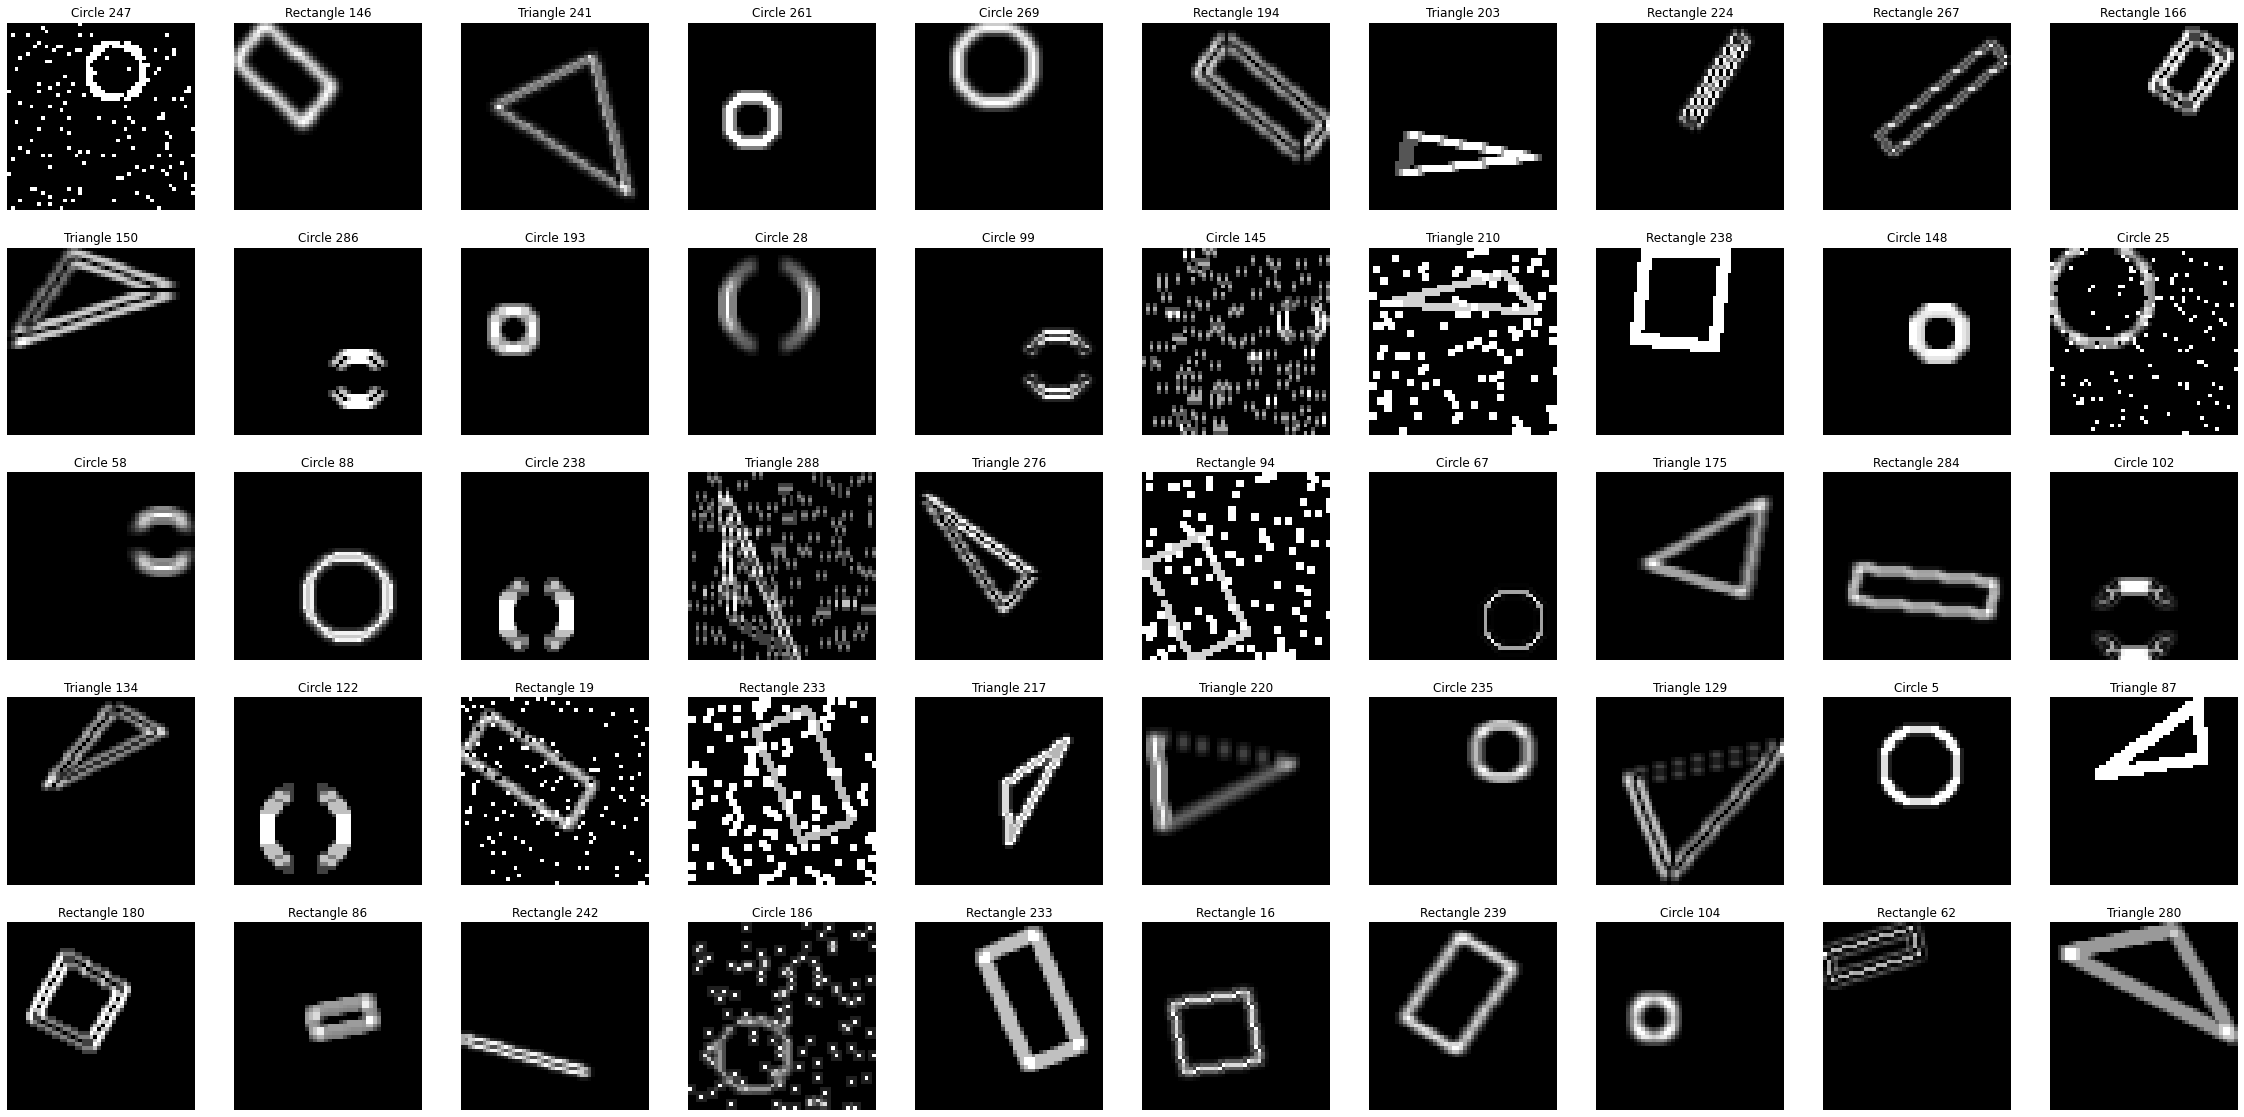

In [41]:
plt.figure(figsize=(40, 20))
for index in range(50):
    plt.subplot(5, 10, index + 1)
    plt.title('{}'.format(augments_label[index]))
    plt.axis("off")
    plt.imshow(augments[index], cmap='gray')
    
plt.show()

## Data Class

In [28]:
class ShapesData:
    def __init__(self, data):
        self.images = []
        self.labels = np.empty(0)

        for (img, lbl) in data:
            self.images.append(img)
            lbl = lbl.split(' ')[0]
            self.labels = np.append(self.labels, lbl)
        
        self.images = np.array(self.images)


    def load_data(self, train_size=.9):

        if train_size > 1 or train_size < 0:
            raise ValueError("Split sizes can not be greater than 1 or less than 0")

        x_train, x_test = np.split(self.images, [ int(train_size * len(self.images)) ])
        y_train, y_test = np.split(self.labels, [ int(train_size * len(self.labels)) ])

        return (x_train, y_train), (x_test, y_test)

In [ ]:
data = ShapesData(zip(augments, augments_label))

In [43]:
(x_train, y_train), (x_test, y_test) = data.load_data()

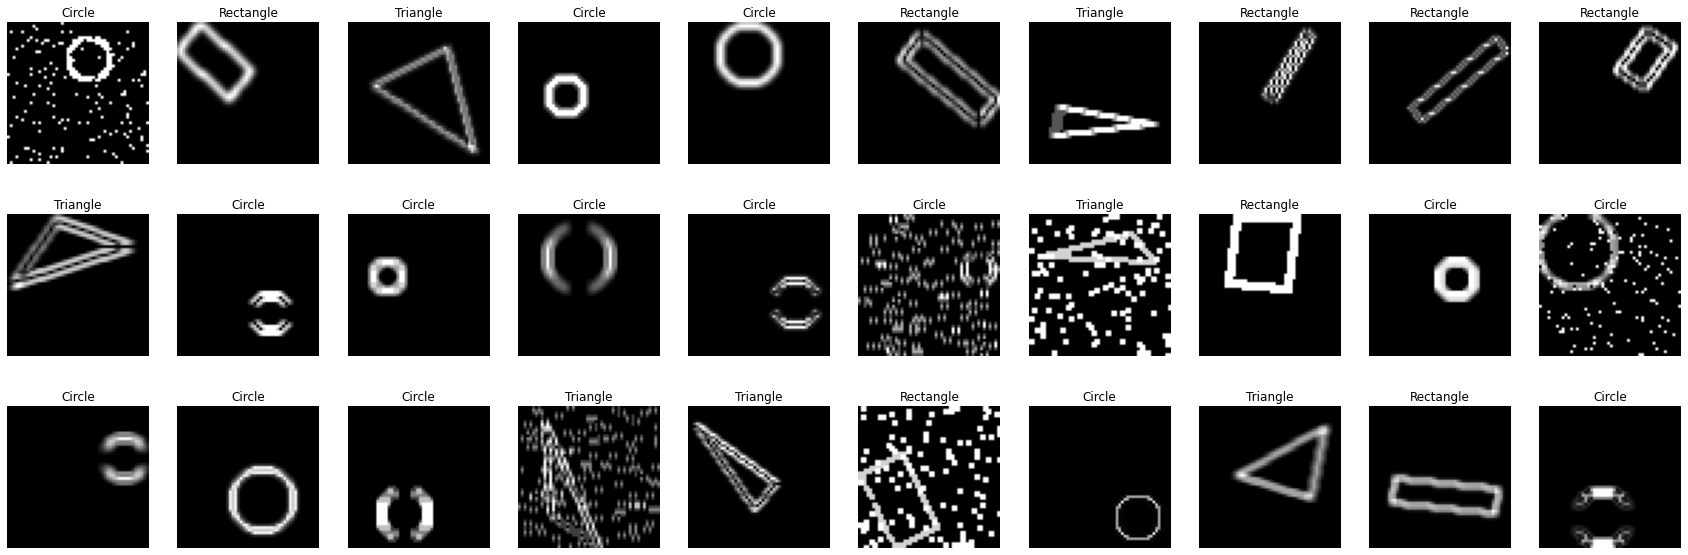

In [44]:
plt.figure(figsize=(30, 10))
for index in range(30):
    plt.subplot(3, 10, index + 1)
    plt.title('{}'.format(y_train[index]))
    plt.axis("off")
    plt.imshow(x_train[index], cmap='gray')
    
plt.show()

## Summary 2
We created 3 functions that create random circles, rectangles, and triangles, and a set of random shapes (300 of each shape).  
After that, we have used the `RandomAugmentation` class from `Part 1` to augment a bunch of these shapes.  
Finally, we created a class that labels and divides the augmented shapes.